In [1]:
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
import bisect
from pyomo.opt import SolverStatus, TerminationCondition

In [20]:
import numpy as np, bisect
import pyomo.environ as pyo
from pyomo.environ import (ConcreteModel, Var, Objective, Constraint, Piecewise,
                           minimize, value, SolverFactory, Expression)
from pyomo.opt import SolverStatus, TerminationCondition
from pyomo.environ import Block

In [24]:
def evaluate_Q_at(model, y_val, solver):
    """
    Fix y=y_val in a scenario model, solve for v(y)=min obj_expr, and return v(y).
    Non-destructive: it temporarily adds/removes an Objective; leaves structure intact.
    """
    # Clear leftovers
    for comp in ['obj', 'As', 'pw']:
        if hasattr(model, comp):
            model.del_component(comp)

    # Fix y, solve
    model.y.fix(y_val)
    model.obj = Objective(expr=model.obj_expr, sense=minimize)
    results = solver.solve(model, tee=False)

    status_ok = (results.solver.status == SolverStatus.ok)
    term_ok = (results.solver.termination_condition == TerminationCondition.optimal)
    if not (status_ok and term_ok):
        raise RuntimeError(f"Scenario evaluate at y={y_val} not optimal: "
                           f"status={results.solver.status}, term={results.solver.termination_condition}")

    v_y = value(model.obj_expr)

    # clean up
    model.del_component('obj')
    model.y.unfix()
    return v_y

def _ensure_clean(model):
    """Remove temporary comps if exist."""
    for comp in ['obj','As','pw','link']:
        if hasattr(model, comp):
            model.del_component(comp)

def _solve_single_ms(model, y_nodes, as_nodes, solver, under_tol=1e-8):
    """
    For one scenario: build As(y) by Piecewise; minimize (obj_expr - As).
    Return (m_value, y_star, active_flag).
    active_flag=False if the gap is within tolerance (≈ already underestimator).
    """
    _ensure_clean(model)
    model.As = Var()
    model.pw = Piecewise(
        model.As, model.y,
        pw_pts=y_nodes,
        f_rule=as_nodes,
        pw_constr_type='EQ',
        pw_repn='SOS2'
    )
    model.obj = Objective(expr=model.obj_expr - model.As, sense=minimize)
    results = solver.solve(model, tee=False)

    status_ok = (results.solver.status == SolverStatus.ok)
    term_ok = (results.solver.termination_condition == TerminationCondition.optimal)
    if not (status_ok and term_ok):
        # 不直接抛错，返回一个保守的“大gap”
        return float('inf'), None, True

    m_val = value(model.obj)            # gap = Q(y) - As(y) at the best y for THIS scenario
    y_star = value(model.y)
    active = not (m_val <= under_tol)
    return m_val, y_star, active



def _build_and_solve_sum_model(model_list, y_nodes, as_nodes_list, bounds, solver):
    N = len(model_list)
    M = ConcreteModel()
    lb, ub = bounds[0], bounds[1]
    M.y = Var(bounds=(lb, ub))

    # 先创建索引块（BlockData 已存在，可直接操作）
    M.scen = Block(range(N))
    for i in range(N):
        # 克隆并清理临时件
        Mi_clone = model_list[i].clone()
        for comp in ['obj','As','pw','link']:
            if hasattr(Mi_clone, comp):
                Mi_clone.del_component(comp)

        # 关键：不要赋值！直接在已存在的 BlockData 上转移组件
        M.scen[i].transfer_attributes_from(Mi_clone)

        # 在该 block 上添加 link / As / pw
        M.scen[i].link = Constraint(expr=M.scen[i].y == M.y)
        M.scen[i].As = Var()
        M.scen[i].pw = Piecewise(
            M.scen[i].As, M.scen[i].y,
            pw_pts=y_nodes,
            f_rule=as_nodes_list[i],
            pw_constr_type='EQ',
            pw_repn='SOS2'
        )

    # 目标：最小化 sum_i (Q_i(y) - A_i(y))
    M.obj = Objective(
        expr=sum(M.scen[i].obj_expr - M.scen[i].As for i in range(N)),
        sense=minimize
    )

    results = solver.solve(M, tee=False)
    ok = (results.solver.status == SolverStatus.ok) and \
         (results.solver.termination_condition == TerminationCondition.optimal)
    if not ok:
        return None, float('inf')

    return value(M.y), value(M.obj)



def nc_underest(bounds, model_list, add_node_num, tolerance=1e-8):
    """
    New logic:
      - per-iteration, compute per-scenario ms_i and y_i^(ms);
      - compute joint y_sum and err_sum via a shared-y sum-model;
      - compare sum(ms_i) vs err_sum and insert the node that corresponds to the larger value.
    """
    N = len(model_list)                          # <<< 这里定义 N
    new_lb, new_ub = bounds[0], bounds[1]

    # solver
    solver = SolverFactory('gurobi')
    solver.options['FeasibilityTol'] = 1e-9
    solver.options['OptimalityTol'] = 1e-9
    solver.options['NonConvex'] = 2

    # init nodes
    y_nodes = [new_lb, 0.0, new_ub]

    # precompute As at initial nodes for each scenario
    as_nodes_list = []
    for i in range(N):
        vals = [evaluate_Q_at(model_list[i], y, solver) for y in y_nodes]
        as_nodes_list.append(vals)

    # reset bounds for each scenario's y
    for i in range(N):
        model_list[i].y.setlb(new_lb)
        model_list[i].y.setub(new_ub)

    eff_node_count = 0
    active = [True] * N
    under_tol = tolerance

    ms_list = [0.0] * N
    new_nodes_list = [None] * N
    last_choice = None

    # 初始化避免未赋值
    err_sum = None
    y_sum = None

    for k in range(len(y_nodes)+1, add_node_num+1):
        # 1) per-scenario
        for i in range(N):
            if not active[i]:
                ms_list[i], new_nodes_list[i] = 0.0, None
                continue
            m_i, y_i, is_active = _solve_single_ms(model_list[i], y_nodes, as_nodes_list[i], solver, under_tol=under_tol)
            ms_list[i] = m_i
            new_nodes_list[i] = y_i
            active[i] = is_active

        # 如果全部inactive，提前结束
        if not any(active):
            delta = (new_ub - new_lb) / 2
            err_sum = 0.0 if err_sum is None else err_sum
            a0 = as_nodes_list[0]
            m0 = ms_list[0] if N >= 1 else 0.0
            a1 = as_nodes_list[1] if N >= 2 else []
            m1 = ms_list[1] if N >= 2 else 0.0
            max_index = int(np.argmax(ms_list)) if len(ms_list) else -1
            new_node = None
            return delta, err_sum, y_nodes, a0, m0, a1, m1, eff_node_count, max_index, new_node

        # 2) sum-model
        y_sum, err_sum = _build_and_solve_sum_model(model_list, y_nodes, as_nodes_list, bounds, solver)

        # 3) decide & insert
        sum_ms = sum(ms_i for ms_i, act in zip(ms_list, active) if act and np.isfinite(ms_i))
        if (err_sum is None) or (not np.isfinite(err_sum)):
            idx = int(np.argmax(ms_list))
            candidate = new_nodes_list[idx]
        else:
            if err_sum > sum_ms:
                candidate = y_sum
            else:
                idx = int(np.argmax(ms_list))
                candidate = new_nodes_list[idx]

        # 4) 插入新节点
        if candidate is not None:
            too_close = any(abs(candidate - yn) <= 1e-8 for yn in y_nodes)
            if not too_close and (k != add_node_num):
                idx_ins = bisect.bisect_left(y_nodes, candidate)
                y_nodes.insert(idx_ins, candidate)
                for i in range(N):
                    val_i = evaluate_Q_at(model_list[i], candidate, solver)
                    as_nodes_list[i].insert(idx_ins, val_i)
                eff_node_count += 1

        if k == add_node_num:
            break

    # 结束兜底
    if (err_sum is None) or (not np.isfinite(err_sum)):
        y_sum, err_sum = _build_and_solve_sum_model(model_list, y_nodes, as_nodes_list, bounds, solver)
        if (err_sum is None) or (not np.isfinite(err_sum)):
            err_sum = float('nan')

    delta = (new_ub - new_lb) / 2
    a0 = as_nodes_list[0]
    m0 = ms_list[0] if N >= 1 else 0.0
    a1 = as_nodes_list[1] if N >= 2 else []
    m1 = ms_list[1] if N >= 2 else 0.0
    max_index = int(np.argmax(ms_list)) if len(ms_list) else -1
    new_node = y_nodes[-1]

    return delta, err_sum, y_nodes, a0, m0, a1, m1, eff_node_count, max_index, new_node


In [25]:
# build function for each scenario
def v_1(y):  
    return - np.sqrt(np.abs(y))

def v_2(y): 
    return np.sqrt(np.abs(y))

v_list = [v_1, v_2]

# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(-1, 1))
m1.x1 = Var(bounds=(0, 1))
m1.x11 = Var(bounds=(0, None))
m1.c1 = Constraint(expr=m1.x11**2 == m1.y**2)
m1.c2 = Constraint(expr=m1.x11 == (m1.x1)**2)
m1.obj_expr = Expression(expr=-m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(-1, 1))
m2.x2 = Var(bounds=(0, 1))
m2.c1 = Constraint(expr=m2.x2**2 >= m2.y)
m2.c2 = Constraint(expr=m2.x2**2 >= -m2.y)
m2.obj_expr = Expression(expr=m2.x2)

model_list = [m1, m2]
# lower bound and upper bound
ylb = -0.2
yub = 0.2
bounds = [ylb, yub]

In [29]:
# make delta list
adds = np.arange(3, 7)
results = [nc_underest([ylb, yub],[m1,m2],a) for a in adds]

   
   
   
effective add node num  0
y node is  [-0.2  0.   0.2]
y node length 3
ms value is  [0.0, 0.0]
new_nodes is  0.2
this time choose scenario  0


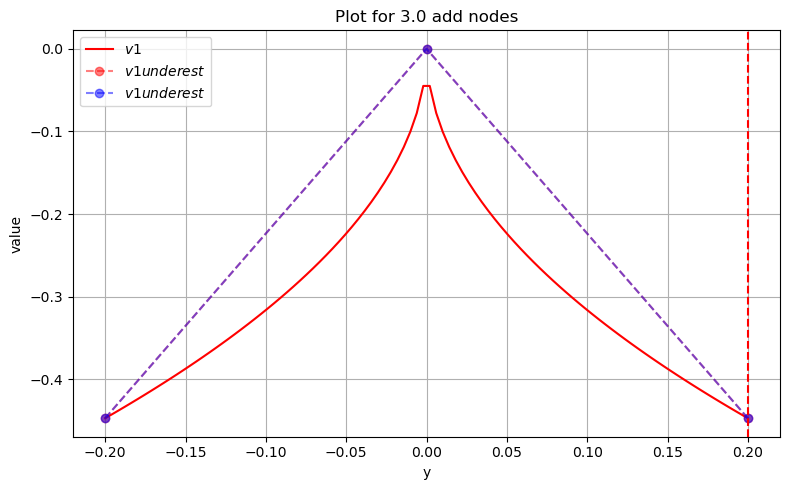

   
   
   
effective add node num  1
y node is  [-0.2  0.   0.2]
y node length 3
ms value is  [-0.11180340533848798, -8.166172182910714e-10]
new_nodes is  None
this time choose scenario  1


TypeError: '>' not supported between instances of 'float' and 'NoneType'

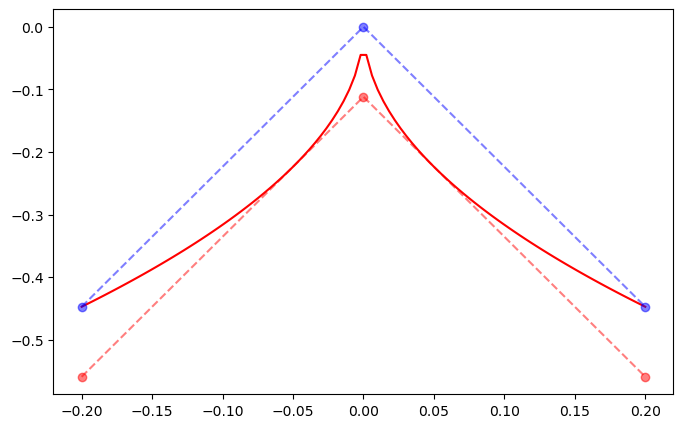

In [30]:
for i in range(len(results)):
    # y and z = |y|
    y_vals = np.linspace(ylb, yub, 100)
    Qs_vals1 = [v_list[0](y) for y in y_vals]
    Qs_vals2 = [v_list[1](y) for y in y_vals]
    Qs_vals_sum = [v_list[0](y)+v_list[1](y) for y in y_vals]

    # As(y)
    y_nodes = np.array(results[i][2])
    as_nodes1 = np.array(results[i][3])
    as_nodes2 = np.array(results[i][5])
    bbb1 = np.array(as_nodes1)
    bbb2 = np.array(as_nodes2)
    bbb_sum = bbb1+bbb2
    ms1 = results[i][4]
    ms2 = results[i][6]
    #err = -results[i][1]
    err = ms1+ms2
    
    print("   ")
    print("   ")
    print("   ")
    print('effective add node num ',results[i][-2])
    print('y node is ',y_nodes)
    print('y node length',len(y_nodes))
    print("ms value is ",[results[i][4],results[i][6]])
    print("new_nodes is ",results[i][-1])
    print("this time choose scenario ",results[i][-2])

    # make the plot
    
    plt.figure(figsize=(8, 5))
    
    plt.plot(y_vals, Qs_vals1, label=r'$v1$', color='red')
    plt.plot(y_nodes, bbb1+ms1,label=r'$v1 underest$',color='red', marker='o',linestyle='--',alpha=0.5)
    plt.plot(y_nodes, bbb1,label=r'$v1 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    '''
    plt.plot(y_vals, Qs_vals2, label=r'$v2$', color='blue')
    plt.plot(y_nodes, bbb2+ms2,label=r'$v2 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    plt.plot(y_vals, Qs_vals_sum, label=r'$v_sum$', color='black')
    plt.plot(y_nodes, bbb_sum+err,label=r'$v_sum underest$',color='black', marker='o',linestyle='--',alpha=0.5)
    '''
    plt.axvline(x=results[i][-1], color='red', linestyle='--')
    #plt.hlines(y=mmm, xmin=ylb, xmax=yub,color='red', linestyle='--')
    
    #plt.xlim(0.05, 0.125)
    #plt.ylim(-0.4, -0.2)
    plt.xlabel('y')
    plt.ylabel('value')
    plt.title(f"Plot for {adds[i]:.1f} add nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

C:\Users\pc\AppData\Local\Temp\ipykernel_25420\262171209.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(adds, np.log(errors), color='red')
C:\Users\pc\AppData\Local\Temp\ipykernel_25420\262171209.py:3: RuntimeWarning: invalid value encountered in log
  plt.plot(adds, np.log(errors), color='red')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-0.002714043715304997, 0.0, 0.0, 0.0]


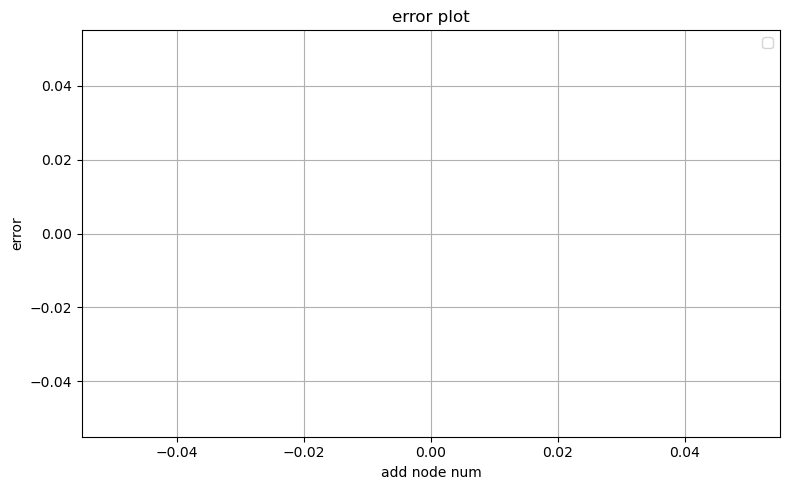

In [28]:
plt.figure(figsize=(8, 5))
errors = [item[1] for item in results]
plt.plot(adds, np.log(errors), color='red')

plt.xlabel('add node num')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()

print(errors)